### Stable Diffusion Pipeline

We'll start by importing the same libraries as before, and also defining the device and correct type.

In [2]:
# !pip install accelerate

In [3]:
import sys

import diffusers
import matplotlib.pyplot as plt
import torch
import transformers
from IPython.display import display
from PIL import Image
from torchinfo import summary
from tqdm.notebook import tqdm

In [4]:
import torch

if torch.backends.mps.is_available():
    device = "mps"
    dtype = torch.float16  # or torch.float32 if needed
elif torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"Using {device} device with {dtype} data type.")


Using mps device with torch.float16 data type.


We'll use the same prompt as before:

In [5]:
prompt = "A red bird flies through a blue sky over a green tree."

If this seems like a lot of work to run Stable Diffusion, you're not alone.  That's why the `StableDiffusionPipeline` was created.  It incorporates all of these steps into a single pipeline object.

In [7]:
pipeline = diffusers.StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", torch_dtype=dtype
)
pipeline.to(device)

print(pipeline)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



You can call it with a prompt, and it returns a container with a list of images.

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x1073A0290>], nsfw_content_detected=[False])
1


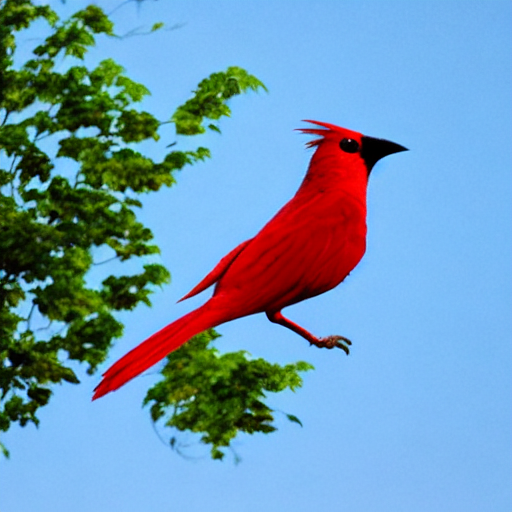

In [8]:
res = pipeline(prompt)

print(res)
print(len(res.images))
# Display the first (and only, in this case) image
display(res.images[0])

In addition to taking a single prompt as input, the pipeline accepts a list of prompts and generates an image for each.  By passing the same prompt in multiple times, we can use this to generate several candidate images.

**Task 6.2.20:** Generate four images for our prompt using the pipeline.  We've provided code that will display all of them.

To reduce the VRAM consumption and avoid "Out of Memory" problems, we'll reduce the size of the desired images:

  0%|          | 0/50 [00:00<?, ?it/s]

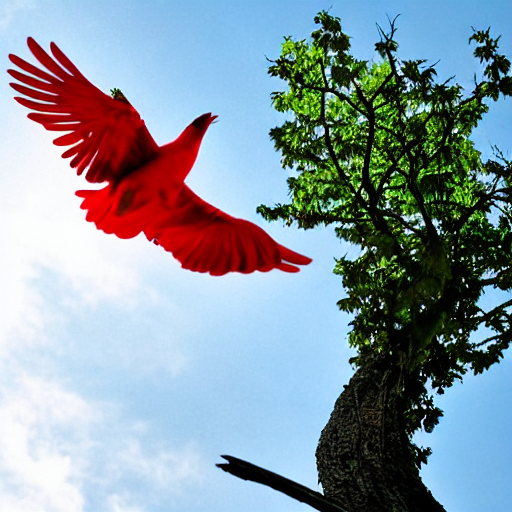

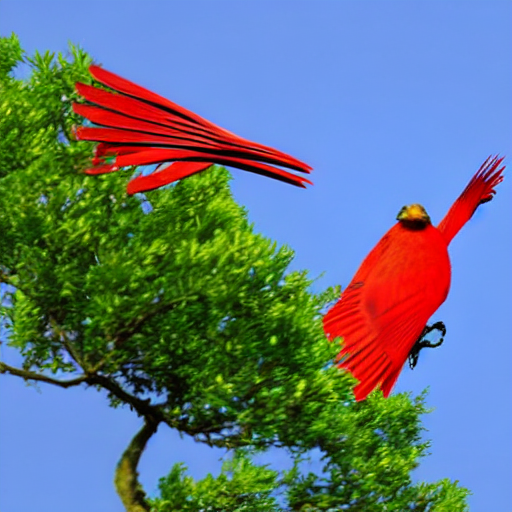

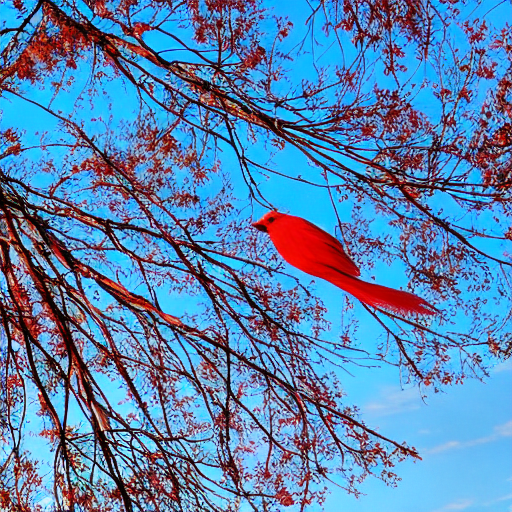

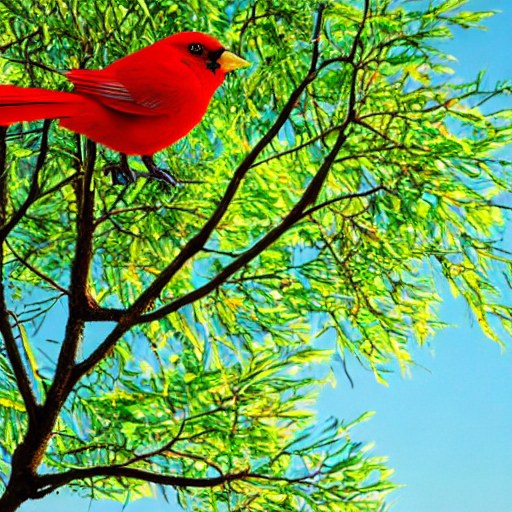

In [9]:
# Create a list containing the prompt four times and pass it to the pipeline.
images = pipeline([prompt]* 4).images

for im in images:
    display(im)

The `pipeline` takes a `guidance_scale` argument.  Small values let the model be more creative, and larger values make it hew more closely to the prompt.  The default value is 7.5.

**Task 6.2.21:** Generate images at small guidance scale (2) and large guidance scale (25) values.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Small guidance


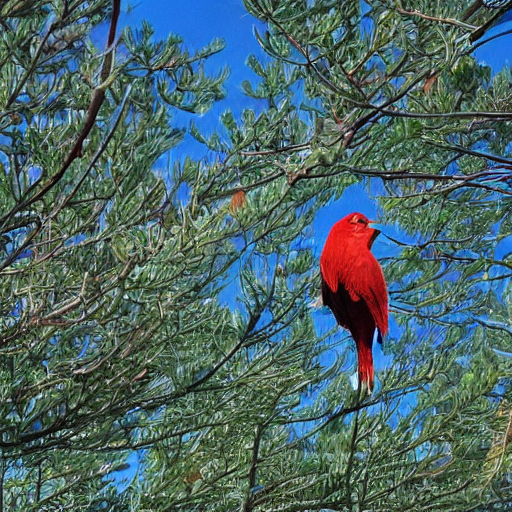

Large guidance


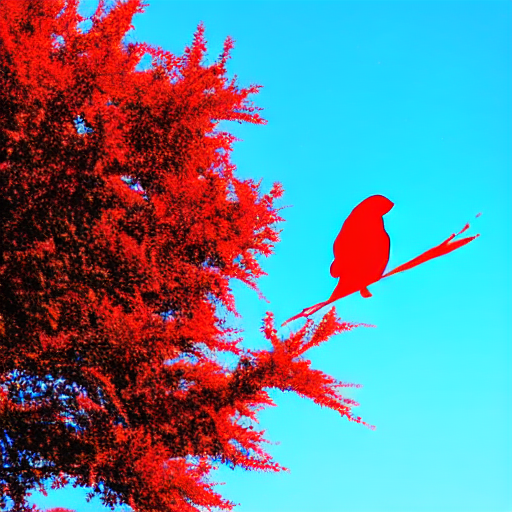

In [10]:
small_guidance = pipeline(prompt, guidance_scale=2).images[0]
large_guidance = pipeline(prompt, guidance_scale=25).images[0]

print("Small guidance")
display(small_guidance)
print("Large guidance")
display(large_guidance)

<div class="alert alert-info" role="alert">
The behavior at different guidance levels becomes more apparent as you see more examples.  You may wish to run the above cell several times.  Alternatively, you can alter it to produce several images at each guidance level.
</div>

We can also adjust the number of denoising steps, with the `num_inference_steps` parameter.  The default is 50 steps.

**Task 6.2.22:** Run the pipeline with only a few (10) and with many (250) steps.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Few steps


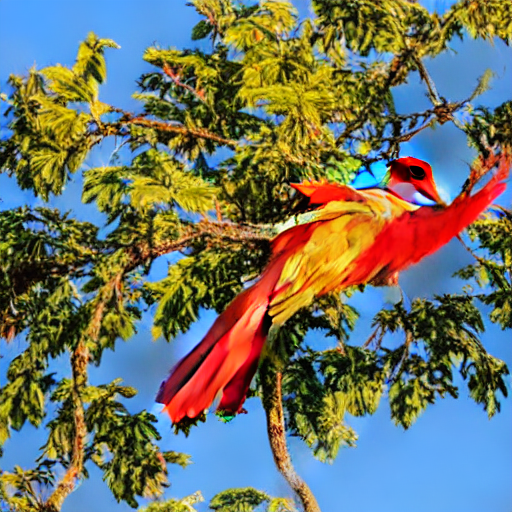

Many steps


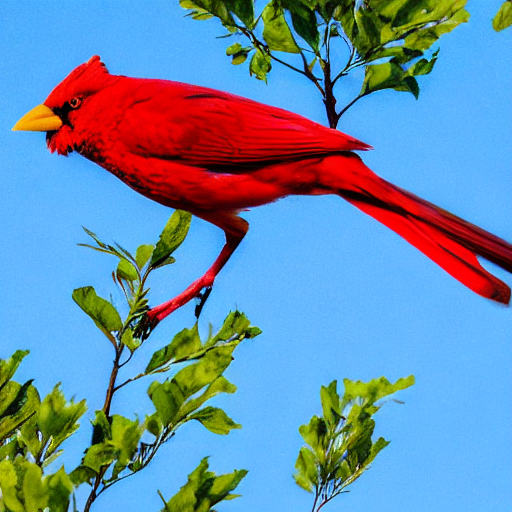

In [11]:
few_steps = pipeline(prompt, num_inference_steps=10).images[0]
many_steps = pipeline(prompt, num_inference_steps=250).images[0]

print("Few steps")
display(few_steps)
print("Many steps")
display(many_steps)

These models tend to be trained on images from sites like Flickr and DeviantArt.  The text descriptions are assembled from summaries, comments, and tags assigned to the images.  That last component means that the training descriptions often consist of a series of keywords, rather than a coherent paragraph about the image.

Our prompts will perform best when they resemble the training data.  Many people have had success by creating prompts that contain lists of keywords and tags that reflect the style they desire.  Here are a couple of different sets of style keywords.

In [ ]:
styles = [
    # A cartoon in Studio Ghibli style
    "cartoon, animated, Studio Ghibli style, cute, Japanese animation",
    # A photograph on film suggests an artistic approach
    "photograph, film, 35 mm camera",
    # A computer rendering.  The "arguments" at the end don't directly
    # affect the image, but they make the model adjust the image to
    # look like images tagged with these arguments.
    "rendered in unreal engine, hyper-realistic, volumetric lighting, --ar 9:16 --hd --q 2",
    # A watercolor painting
    "painting, watercolors, pastel, composition",
    # Add your own, too!
]

We can steer the model towards our style by adding these to our prompt.  For example, to generate our bird in a cartoon style, we could do:

In [ ]:
styled_prompt = f"{prompt} {styles[0]}"
image = pipeline(styled_prompt).images[0]

print(styled_prompt)
display(image)

**Task 6.2.23:** Generate an image using our prompt and each of these styles.

In [ ]:
styled_prompts = [f"{prompt} {style}" for style in styles]
images = pipeline(styled_prompts).images

for p, i in zip(styled_prompts, images):
    print(p)
    display(i)